[Forecasting: Principles and Practice](https://otexts.com/fpp2/)

In [28]:
from graph_traffic.get_data import get_data
from graph_traffic.config import figures_path
from graph_traffic.dataloading import npzDataset
from graph_traffic.baseline_models import MeanRegressor, MedianRegressor, RepeatRegressor, RepeatLastRegressor, DaytimeRegressor, DriftRegressor
from graph_traffic.model_selection import timeseries_cv, plot_predictions, print_losses
from random import choices

baseline_path = figures_path + "/baseline"

data_dict = dict(
    ids_list=[1001],
    seq_len=12,
    with_graph=False,
    from_date="2019-01-01",
    to_date="2019-12-31",
    dataset_name="small",
    target="intensidad",
    interactions=None
)

meteo_dict = dict(
    rain="drop",
    wind="drop",
    temperature="drop",
    humidity="drop",
    pressure="drop",
    radiation="drop"
)

temporal_dict = dict(
    year="drop",
    season="drop",
    month="drop",
    day_of_month="drop",
    weekday="drop",
    hour="drop",
    minute="drop",
    bank_holiday="drop",
    school_holiday="drop",
    working_day="drop",
    state_of_alarm="drop"
)

get_data(data_dict, meteo_dict, temporal_dict)
dataset_name = data_dict["dataset_name"]
n_points = None

In [29]:
train_data = npzDataset(dataset_name, "train", n_points)
test_data = npzDataset(dataset_name, "test", n_points)

train_x = train_data.x
train_y = train_data.y

test_x = test_data.x
test_y = test_data.y

In [30]:
random_samples = choices(range(test_x.shape[0]), k=2)
random_samples

[5582, 3709]

In [31]:
train_x.shape

(24359, 12, 1, 3)

# 1. Mean regressor

In [32]:
estimators, train_losses, test_losses = timeseries_cv(MeanRegressor(), train_x, train_y)
print_losses(train_losses, test_losses)

Train MAE: 1082.72, std: 53.46
Train MSE: 1634565.13, std: 119641.22
Test MAE: 979.04, std: 31.04
Test MSE: 1426560.39, std: 76029.43


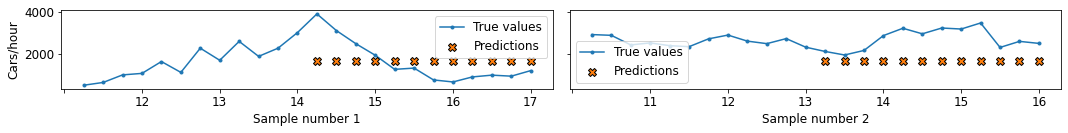

In [33]:
plot_predictions(estimators[0], test_x, test_y, random_samples, data_dict["ids_list"], data_dict["seq_len"], name_save=baseline_path + "/mean.png")

# 2. Median regressor

In [34]:
estimators, train_losses, test_losses = timeseries_cv(MedianRegressor(), train_x, train_y)
print_losses(train_losses, test_losses)

Train MAE: 1081.75, std: 53.91
Train MSE: 1639303.48, std: 117326.96
Test MAE: 978.35, std: 28.88
Test MSE: 1425582.44, std: 70460.06


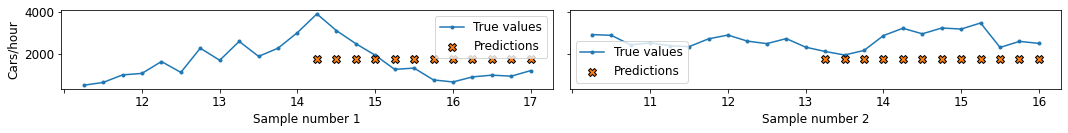

In [35]:
plot_predictions(estimators[0], test_x, test_y, random_samples, data_dict["ids_list"], data_dict["seq_len"], name_save=baseline_path + "/median.png")

# 3. Repeat regressor

In [36]:
estimators, train_losses, test_losses = timeseries_cv(RepeatRegressor(), train_x, train_y)
print_losses(train_losses, test_losses)

Train MAE: 964.64, std: 6.06
Train MSE: 2035902.51, std: 44324.99
Test MAE: 993.75, std: 37.40
Test MSE: 2049488.44, std: 151144.28


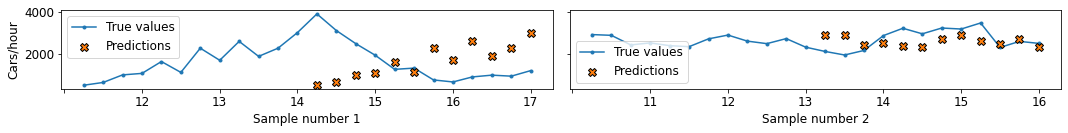

In [37]:
plot_predictions(estimators[0], test_x, test_y, random_samples, data_dict["ids_list"], data_dict["seq_len"], name_save=baseline_path + "/repeat.png")

# 4. Repeat last value regressor

In [38]:
estimators, train_losses, test_losses = timeseries_cv(RepeatLastRegressor(), train_x, train_y)
print_losses(train_losses, test_losses)

Train MAE: 637.13, std: 3.99
Train MSE: 1091549.36, std: 28178.55
Test MAE: 657.28, std: 25.10
Test MSE: 1100605.66, std: 98004.25


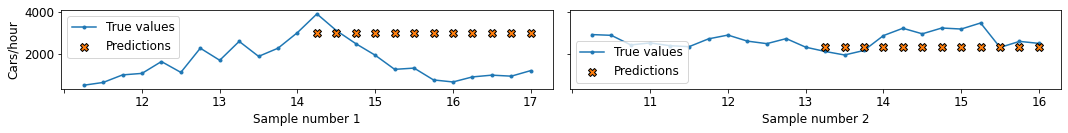

In [39]:
plot_predictions(estimators[0], test_x, test_y, random_samples, data_dict["ids_list"], data_dict["seq_len"], name_save=baseline_path + "/repeat_last.png")

# 5. Mean per hour

In [40]:
estimators, train_losses, test_losses = timeseries_cv(DaytimeRegressor("mean"), train_x[:, :, :, [0, 1]], train_y)
print_losses(train_losses, test_losses)

Train MAE: 592.14, std: 48.78
Train MSE: 817045.59, std: 154892.43
Test MAE: 483.93, std: 29.89
Test MSE: 532184.44, std: 36335.43


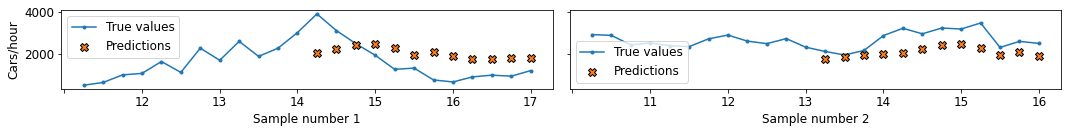

In [41]:
plot_predictions(estimators[0], test_x, test_y, random_samples, data_dict["ids_list"], data_dict["seq_len"], name_save=baseline_path + "/mean_hour.png")

In [42]:
estimator, train_losses, test_losses = timeseries_cv(DaytimeRegressor("mean", by_working_day=True), train_x[:, :, :, [0, 1, 2]], train_y)
print_losses(train_losses, test_losses)

Train MAE: 442.08, std: 51.74
Train MSE: 532351.56, std: 179181.37
Test MAE: 324.25, std: 37.34
Test MSE: 199328.58, std: 42403.87


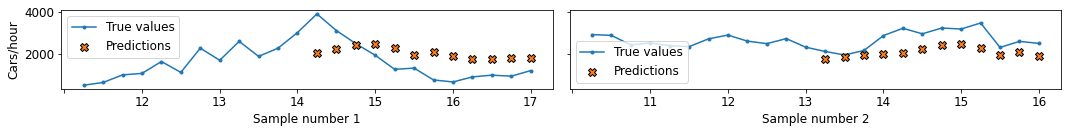

In [43]:
plot_predictions(estimators[0], test_x, test_y, random_samples, data_dict["ids_list"], data_dict["seq_len"], name_save=baseline_path + "/mean_hour_workingday.png")

# 6. Median per hour

In [44]:
estimators, train_losses, test_losses = timeseries_cv(DaytimeRegressor("median"), train_x[:, :, :, [0, 1]], train_y)
print_losses(train_losses, test_losses)

Train MAE: 576.22, std: 51.73
Train MSE: 977742.43, std: 158657.40
Test MAE: 478.07, std: 35.81
Test MSE: 679829.21, std: 91833.87


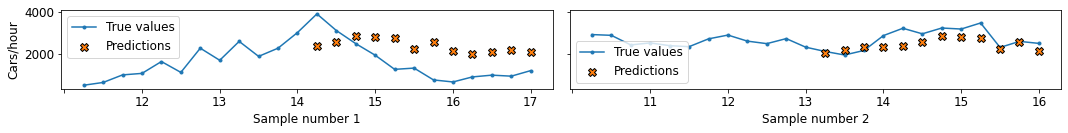

In [45]:
plot_predictions(estimators[0], test_x, test_y, random_samples, data_dict["ids_list"], data_dict["seq_len"], name_save=baseline_path + "/median_hour.png")

In [46]:
estimators, train_losses, test_losses = timeseries_cv(DaytimeRegressor("median", by_working_day=True), train_x[:, :, :, [0, 1, 2]], train_y)
print_losses(train_losses, test_losses)

Train MAE: 426.10, std: 60.27
Train MSE: 554589.15, std: 177721.11
Test MAE: 313.51, std: 29.76
Test MSE: 198266.22, std: 37788.43


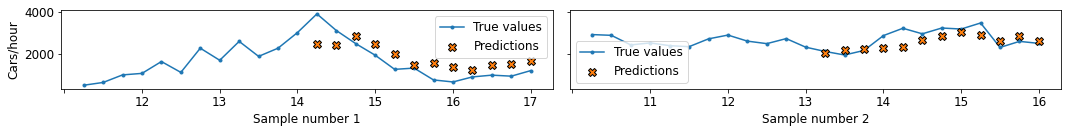

In [47]:
plot_predictions(estimators[0], test_x, test_y, random_samples, data_dict["ids_list"], data_dict["seq_len"], name_save=baseline_path + "/median_hour_workingday.png")

# 7. Drift regressor

In [48]:
estimators, train_losses, test_losses = timeseries_cv(DriftRegressor(), train_x, train_y)
print_losses(train_losses, test_losses)

Train MAE: 827.31, std: 3.11
Train MSE: 1987476.64, std: 55392.74
Test MAE: 857.11, std: 37.09
Test MSE: 2024075.23, std: 202878.31


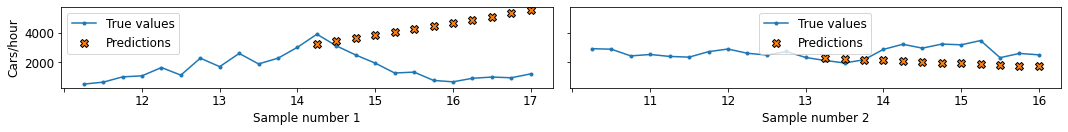

In [49]:
plot_predictions(estimators[0], test_x, test_y, random_samples, data_dict["ids_list"], data_dict["seq_len"], name_save=baseline_path + "/drift.png")